# Dremio Test

## Imports

In [1]:
import os
import sys
import atoti as tt

In [5]:
import pandas as pd

Make sure you are running a version of atoti older than 0.8.10. This has been tested on 0.8.5

In [2]:
tt._version.VERSION

'0.8.6'

### Jar Input

In [3]:
# dremio_driver_customized_jar = "dremio-driver-1.0-SNAPSHOT-jar-with-dependencies.jar"
# dremio_driver_legacy_jar = "dremio-jdbc-driver-1.0.8-201707190805180330-27f36e1.jar"
dremio_driver_jar="flight-sql-jdbc-driver-10.0.0.jar"

### SQL Setup

In [4]:
schema_name='"@admin"'
db_table_name='"0_0_1"'
sql = f"SELECT * FROM {schema_name}.{db_table_name}"
sql2 = f"SELECT sens_dataset_status_dataset_name, amount FROM {schema_name}.{db_table_name}"

### Database setup

In [6]:
username="admin"
password="admin01!"
host_name="localhost"
port="32010"
database = "Dremio"

jdbc_legacy_url=f"jdbc:dremio:direct={host_name}:31010"
jdbc_url = f"jdbc:arrow-flight-sql://{host_name}:{port}?user={username}&password={password}&useEncryption=false"

jdbc_driver="org.apache.arrow.driver.jdbc.ArrowFlightJdbcDriver"
jdbc_legacy_driver="com.dremio.jdbc.Driver"
atoti_table_name="dremio_sample"

In [7]:
os.getcwd()

'/Users/gpadya/Documents/dremio-driver/Python Dremio Demo'

In [8]:
session = tt.Session(
    port=9092,
    user_content_storage = "./Python Dremio Demo/content",
    # java_options=["-Dorg.springframework.boot.logging.LoggingSystem=none"],
    extra_jars=[f"./utilities/extra_jars/{dremio_driver_jar}"],
    # app_extensions=tt.ADVANCED_APP_EXTENSION,
    # logging=tt.LoggingConfig(destination=sys.stdout)
    logging=tt.LoggingConfig(destination="./logging/server.log")
)

In [9]:
# dremio_sample=session.create_table(
#     name=atoti_table_name,
#     types = {"trade_dataset_id":tt.INT, "amount": tt.DOUBLE}
# )

In [10]:
# session.tables

In [11]:
# dremio_sample.load_sql(sql2,
#                 url=jdbc_url, 
#                 driver=jdbc_driver)

In [12]:
%%time
dremio_sample=session.read_sql(sql2,
                url=jdbc_url, 
                driver=jdbc_driver,
                table_name=atoti_table_name,
                # types = {"sens_dataset_status_dataset_name":tt.STRING, 
                #          "amount": tt.DOUBLE}
                
                 )

CPU times: user 11.3 ms, sys: 5.97 ms, total: 17.3 ms
Wall time: 11 s


In [13]:
dremio_sample

In [14]:
session.create_cube(dremio_sample)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
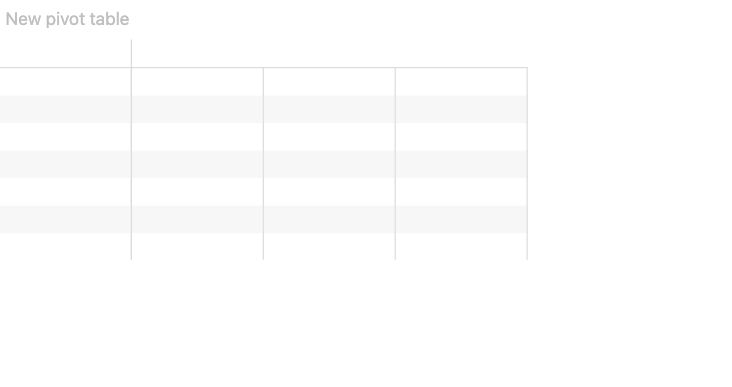

In [15]:
session.widget